# СТЕГОАНАЛИЗ ИЗОБРАЖЕНИЙ С ПОМОЩЬЮ ГЛУБОКОГО МАШИННОГО ОБУЧЕНИЯ 

## Аннотация
Рассматривается современное состояние проблемы стегоанализа цифровых изображений, направленной на исследование и разработку эффективных методов выявления стеганографически скрытых (визуально незаметных) сообщений в контейнерах- изображениях.

## Содержание

1. [Импорт необходимых библиотек](#first)
2. [Получение и предобработка данных](#second)

## 1. Импорт необходимых библиотек
<span id="first"></span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage import io, transform
from IPython.display import clear_output

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import torch, torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

import os
import string
import random
from tqdm import tqdm
import time

from stegano import exifHeader

## 2. Получение и предобработка данных

In [2]:
pictures_names = os.listdir('data/')

pictures_clear = pictures_names[:round(len(pictures_names) * 0.65)]
pictures_clear_df = pd.DataFrame({
    "picture_link": pictures_clear,
    "is_clear": np.ones(len(pictures_clear), dtype=int)
})

pictures_graphed = pictures_names[round(len(pictures_names) * 0.65):]
pictures_graphed_df = pd.DataFrame({
    "picture_link": pictures_graphed,
    "is_clear": np.zeros(len(pictures_graphed), dtype=int)
})

data = shuffle(pd.concat([pictures_clear_df, pictures_graphed_df]))
data.reset_index(drop=True, inplace=True)
data.picture_link = data.picture_link.apply(lambda val: "data/" + val)
data = data[data.picture_link != "data/.DS_Store"]

def image_resizing(link):
    img = Image.open(link)
    img = img.resize((128,128))
    img.save(link)
    return link

data.picture_link.apply(image_resizing)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 8000
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   picture_link  8000 non-null   object
 1   is_clear      8000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 187.5+ KB


,picture_link,is_clear
0,data/cat.1375.jpg,1
1,data/dog.1895.jpg,1
2,data/cat.2789.jpg,0
3,data/cat.488.jpg,1
4,data/cat.692.jpg,1


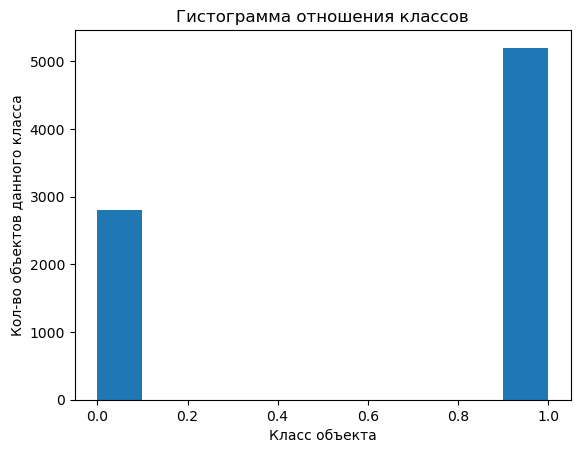

In [3]:
plt.hist(data.is_clear)
plt.xlabel("Класс объекта")
plt.ylabel("Кол-во объектов данного класса")
plt.title("Гистограмма отношения классов");

## 3. Стенография

In [4]:
def preprocess_images(row):
    try:
        image_link = row["picture_link"]
        is_clear = row["is_clear"]

        image = Image.open(image_link)
        image.load()

        im = Image.new('RGB', image.size, (255, 255, 255))
        im.paste(image, None)
        im.save(image_link)


        secret_text = ""
        new_link = "data_prepared/" + image_link.split("/")[1].split(".")[0] + image_link.split("/")[1].split(".")[1] + ".jpg"
        
        if not bool(is_clear):
            secret_text = ''.join(random.choice(string.ascii_letters) for i in range(200))
            secret = exifHeader.hide(image_link, new_link, secret_message=secret_text)
        
        else:
            image.save(new_link)

        row["picture_link"] = new_link 
        row["secret"] = secret_text
    except:
        pass
    
    return row
    

In [5]:
data["secret"] = np.nan

In [6]:
for index in tqdm(range(0, data.shape[0], 5)):
    data[index:index + 5] = data[index:index + 5].apply(preprocess_images, axis=1)

100%|██████████████████████████████████████| 1600/1600 [00:09<00:00, 171.69it/s]


In [7]:
data.sample(10)

,picture_link,is_clear,secret
5541,data_prepared/dog1951.jpg,0,fxdQvhYfNCeIAXdLrwXFFPuFVfKvZYFAMDIJmJuoARgZMs...
104,data_prepared/dog50.jpg,1,
4337,data_prepared/dog658.jpg,1,
614,data_prepared/cat3767.jpg,1,
3900,data_prepared/cat3228.jpg,1,
5715,data_prepared/cat2314.jpg,0,hluXaMGprIArsJZPZErqAuDLssvQlKEaxNcvcPFyxQiMpT...
2,data_prepared/cat2789.jpg,0,EMaEQHcqchNQihLkaCGrnuGmJpeMdBTZckgxBENRCLmbUp...
3965,data_prepared/cat430.jpg,0,lcsdxeMPBFhlzKBtGumYTaRluCxUyCwkOBjJsIAwFKEhXS...
32,data_prepared/dog2819.jpg,1,
2972,data_prepared/cat1892.jpg,1,


In [8]:
print(exifHeader.reveal("data_prepared/cat3127.jpg"), Image.open("data_prepared/cat3127.jpg").size)

b'pHkLUTlmwLfDYwDIFBJZoEUypMSScrDGSgHaHXQptVZYligOPzGvLiHcqNOgFFwTErhNvhuTbFkFinNshSIxAEXMIuLoASkhLYSPpsescrtTihNuEgQJVVDpenUxBTsYEfykTRuxrWEGprEGLevOVatwGfGZoayyCutzsXFZNiQeyNHSBgyddKCdYccZVrfwLgcsTKTn' (128, 128)


In [9]:
data.to_csv("data_marked.csv", index=False)

## DataLoader

In [10]:
class Dataset(Dataset):
    """Описантельный класс датасета для удобной работы с ним"""

    def __init__(self, csv_file=None, transform=None):
        """
            Args:
                csv_file (string): Путь к csv файлу с разметкой
                transform (callable, optional): Опционально, трансформации применяемые к картинкам
        """
        
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return self.annotations.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_info = self.annotations.iloc[idx]
        image = io.imread(img_info[0])
        label = img_info[1]
        
        if self.transform:
            image = self.transform(image)

        if len(image.shape) == 2 or image.shape[0] == 1: # если черно-белая
            image = image.repeat( 3, 1, 1)
            
        sample = image, label

        return sample

In [11]:
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((128, 128)), transforms.ToTensor()])
train_dataset = Dataset(csv_file='data_marked.csv', transform=transform)

part = np.arange(0, len(train_dataset))
val_part = np.arange(int(len(train_dataset) * 0.7), len(train_dataset))

sampler_to_train = torch.utils.data.SubsetRandomSampler(part)
sampler_to_val = torch.utils.data.SubsetRandomSampler(val_part)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler_to_train) 
validate_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler_to_val)

torch.Size([64, 3, 128, 128]) tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0])


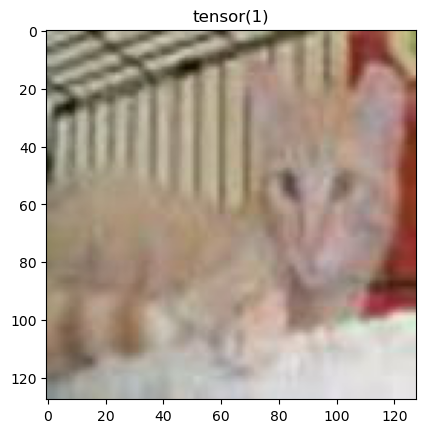

In [13]:
for image, label in train_loader:
    print(image.shape, label)
    plt.imshow(image[0].transpose(0, -1).transpose(1, 0))
    plt.title(label[0])
    plt.show();
    break

## Нейросеть

In [14]:
class GaussianActivation(nn.Module):
    def __init__(self, mean=0, std=np.random.choice(np.arange(0.01, 0.5, 0.01)), min=0.1, max=0.9):
        super(GaussianActivation, self).__init__()
        self.mean = mean
        self.std = std
        self.min = min
        self.max = max

    def forward(self, x):
        gauss = torch.exp((-(x - self.mean) ** 2) / (2* self.std ** 2))
        return torch.clamp(gauss, min=self.min, max=self.max)

In [15]:
class Net:
    def __init__(self, lr=1e-2, epoch=5):
        self.model = nn.Sequential(
                
            nn.Conv2d(3, 16, kernel_size=(5, 5)),            
            nn.BatchNorm2d(16),
            GaussianActivation(),
            
            nn.AvgPool2d(kernel_size=(3, 3), stride=2),
            
            nn.Conv2d(16, 64, kernel_size=(3, 3)),            
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.AvgPool2d(kernel_size=(3, 3), stride=2),
            
            nn.Conv2d(64, 128, kernel_size=(3, 3)),            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Flatten(),
            
            nn.Linear(93312, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 2),
            nn.Softmax()
        )
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.epoch = epoch
        
    def validation(self, val_loader):
        accuracy_list = []
        for xb, yb in val_loader:
            with torch.no_grad():
                y_pred = torch.argmax(self.model(xb), dim=-1)
                
                accuracy_list.append(accuracy_score(y_pred, yb))
            
        return np.mean(np.array(accuracy_list))
            
    def fit(self, train_loader, val_loader):
        for i in range(self.epoch):
            counter = 1
            for X, y in tqdm(train_loader):
                print(f'Iteration {counter} started')
                counter += 1
                clear_output(wait=True)
                
                y_pred = self.model(X)
                loss = F.cross_entropy(y_pred, y)
                
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                
            accuracy = self.validation(val_loader)
            print("Accuracy in:", accuracy)
            print(f'Epoch {i + 1} is finished!')
            time.sleep(10)
            
    def predict(self, X):
        with torch.no_grad():
            return torch.argmax(self.model(X), dim=-1)
        

In [16]:
m = Net()

In [17]:
m.fit(train_loader, validate_loader)

 25%|██████████▍                               | 31/125 [00:17<00:52,  1.80it/s]


KeyboardInterrupt: 